In [1]:
#réseau de neuronne pouvant résoudre un problème de classification sur 2 classes:
#une classe étant l'ensemble des point sur la boule unité
#l'autre étant un ensemble de point décalé par un bruit du cerce de rayon 2 centré en 0

import numpy as np
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

from main import *

def generedata(N=10000,propc1=0.5,seed = 42):
    mu, sigma = 0, 0.25
    res = []
    label = []
    np.random.seed(seed)
    while len(res)<N:
        if np.random.rand() < propc1: #classe 1 boule unité
            label.append(1)
            tmp = 2*np.random.rand(2) - 1
            while np.linalg.norm(tmp,ord =2) > 1:
                tmp = 2 * np.random.rand(2) - 1
            res.append(tmp)
        else: #classe 0 cercle bruité
            label.append(0)
            r =  min(3,np.random.normal(2, sigma))
            theta = 2*np.pi * np.random.rand()
            res.append(np.array([r*np.cos(theta),r*np.sin(theta)]))
    return np.array(res),np.array(label)

def scoring(Y_pred,Y_test):
    n = Y_pred.size
    cpt = 0
    for i in range(n):
        if Y_pred[i] == Y_test[i]:
            cpt += 1
    return 100*cpt/n




In [2]:
X_train,Y_train = generedata()
MLP = MLPClassifier(random_state = 15,hidden_layer_sizes = (3,2),alpha = 0, max_iter = 1000) #4 couches, 2 cachées, une output binaire
MLP.fit(X_train, Y_train)

for s in [10,53135,38,52,64]: #vérification
    X_test,Y_test = generedata(N = 2000,seed = s)
    Y_pred = MLP.predict(X_test)
    assert scoring(Y_pred,Y_test) > 99

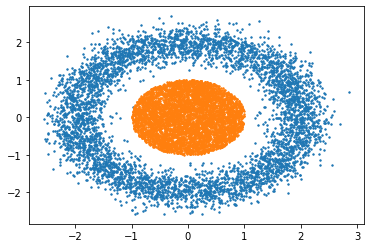

In [3]:
plt.scatter(X_train[np.where(Y_train ==0)][:,0],X_train[np.where(Y_train ==0)][:,1],s=2)
plt.scatter(X_train[np.where(Y_train ==1)][:,0],X_train[np.where(Y_train ==1)][:,1],s=2)

In [4]:
def sigmoid(x):
    sig = 1 / (1 + np.exp(-x))
    return sig

#MLP.coefs_ == [np.array([[ 1.53548563, -0.70261024, -1.09584091],[ 0.22327585, -1.75634826,  1.2725087 ]]),np.array([[1.35959981, 1.52614459],[1.28701428, 1.4447345 ],[1.34305945, 1.50734253]]),np.array([[-7.37523135],[-4.95463279]])]

def discretize(X,l=[-3+i*0.06 for i in range(101)]):
    """
    Transforme X \in R en X in l
    """
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i,j] = min(l, key=lambda x:abs(x-X[i,j]))
    return X

def f1(u,w): #simule le passage de l'input a la premiere couche cachee
    res = u @ w
    for i in range(res.shape[0]):
        res[i] = int(max(0,res[i]))
    return res

def f2(v,w):#simule le passsage de la premiere couche cachee a la deuxieme
    res = v @ w
    for i in range(res.shape[0]):
        res[i] = int(max(0,res[i]))
    return res

def f3(v,w): #simule le passage de la deuxieme couche cachee a l'output
    res = v @ w
    for i in range(res.shape[0]):
        res[i] = int(sigmoid(res[i])>1e-6)
    return res

def my_NN(inp,w0,w1,w2): #simule le reseau de neurone complet "discretisé"
    pred = []             
    for u in inp:
        v0 = f1(u,w0) 
        v1 = f2(v0,w1)
        v2 = f3(v1,w2) 
        pred.append(v2[0])
    return pred

In [5]:
w0 = MLP.coefs_[0]
w1 = MLP.coefs_[1]
w2 = MLP.coefs_[2]

for s in [38541351,351,61868,98465,35743]:
    X_test,Y_test = generedata(N = 20000,seed = 19)
    X_test = discretize(X_test,[-3+i*0.06 for i in range(101)])
    Y_pred = np.array(my_NN(X_test,w0,w1,w2))
    assert scoring(Y_pred,Y_test) > 95

In [6]:
U = {'u0': [-3+i*0.06 for i in range(101)],\
    'u1':[-3+i*0.06 for i in range(101)]} 
V = {'v00' : [i for i in range(4)],
     'v01' : [i for i in range(5)],\
     'v02' : [i for i in range(4)],\
     
     'v10' : [i for i in range(6)],\
     'v11' : [i for i in range(7)],\
     
     'output' : [0,1]}

w0 = MLP.coefs_[0]
w1 = MLP.coefs_[1]
w2 = MLP.coefs_[2]

def compute_v00(param):
    u0 = param['u0']
    u1 = param['u1']
    return int(max(0,np.array([u0,u1]) @ w0[:,0]))

def compute_v01(param):
    u0 = param['u0']
    u1 = param['u1']
    return int(max(0,np.array([u0,u1]) @ w0[:,1]))

def compute_v02(param):
    u0 = param['u0']
    u1 = param['u1']
    return int(max(0,np.array([u0,u1]) @ w0[:,2]))

def compute_v10(param):
    v00 = param['v00']
    v01 = param['v01']
    v02 = param['v02']
    return int(max(0,np.array([v00,v01,v02]) @ w1[:,0]))
               
def compute_v11(param):
    v00 = param['v00']
    v01 = param['v01']
    v02 = param['v02']
    return int(max(0,np.array([v00,v01,v02]) @ w1[:,1]))
               
def compute_output(param):
    v10 = param['v10']
    v11 = param['v11']
    res = np.array([v10,v11]) @ w2
    return int(sigmoid(res)>1e-6)

P = {'v00' : (['u0','u1'],compute_v00),\
     'v01' : (['u0','u1'],compute_v01),\
     'v02' : (['u0','u1'],compute_v02),\
     
     'v10' : (['v00','v01','v02'],compute_v10),\
     'v11' : (['v00','v01','v02'],compute_v11),\
     
     'output' : (['v10','v11'],compute_output)
    }
C = {'u0' : ['v00','v01','v02'],\
     'u1' : ['v00','v01','v02'],\
     'v00' : ['v10','v11'],\
     'v01' : ['v10','v11'],\
     'v02' : ['v10','v11'],\
     'v10' : ['output'],\
     'v11' : ['output'],\
    }

Graph = CausalGraph(P,C)
Mod = Model(U,V,Graph)

X,Y = generedata(N = 1,seed = 9630)
X = discretize(X)
#print((X[0],Y[0]))

Y = Y[0]
u = {'u0': X[0][0],\
     'u1': X[0][1]}
v = dict()

Sit = Situation(Mod,u,v)


In [7]:
fact = {'v11':3}
l = actual_cause_generator(fact,Sit)
for c in l:
    assert test_AC1(c,fact,Sit)
    assert test_AC2(c,fact,Sit)
    assert test_AC3(c,fact,Sit)

In [8]:
foil = {'v10':1}
counterfactual_cause_generator(fact,foil,Sit)

[({'v02': 1}, {'v02': 0}), ({'v01': 0}, {'v01': 1}), ({'v00': 1}, {'v00': 0})]

In [9]:
fact = {'output' : 0}
foil = {"output" : 1}
counterfactual_cause_generator(fact,foil,Sit)

[({'v02': 1}, {'v02': 0}),
 ({'v02': 1}, {'v02': 2}),
 ({'v02': 1}, {'v02': 3}),
 ({'v00': 1}, {'v00': 0}),
 ({'v00': 1}, {'v00': 2}),
 ({'v00': 1}, {'v00': 3}),
 ({'v11': 3}, {'v11': 0}),
 ({'v11': 3}, {'v11': 1}),
 ({'v11': 3}, {'v11': 2}),
 ({'v10': 2}, {'v10': 0}),
 ({'v10': 2}, {'v10': 1})]

In [10]:
fact = {'output' : 0}
foil = {'v10':1}
counterfactual_cause_generator(fact,foil,Sit)

[({'v02': 1}, {'v02': 0}),
 ({'v00': 1}, {'v00': 0}),
 ({'v11': 3}, {'v11': 0}),
 ({'v11': 3}, {'v11': 1}),
 ({'v11': 3}, {'v11': 2}),
 ({'v11': 3}, {'v11': 4}),
 ({'v11': 3}, {'v11': 5}),
 ({'v11': 3}, {'v11': 6})]

In [11]:
fact = {'v10' : 2}
foil = {'output':1}
counterfactual_cause_generator(fact,foil,Sit)

[({'v02': 1}, {'v02': 0}),
 ({'v02': 1}, {'v02': 2}),
 ({'v02': 1}, {'v02': 3}),
 ({'v01': 0}, {'v01': 1}),
 ({'v01': 0}, {'v01': 2}),
 ({'v01': 0}, {'v01': 3}),
 ({'v01': 0}, {'v01': 4}),
 ({'v00': 1}, {'v00': 0}),
 ({'v00': 1}, {'v00': 2}),
 ({'v00': 1}, {'v00': 3})]